<a href="https://colab.research.google.com/github/GarettGazay/ai_projects/blob/master/RouteBuilder_TFR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [183]:
!pip install transformers 
!pip install sentencepiece
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [184]:
import pandas as pd

In [185]:
df = pd.read_csv('ordering_dataset.csv')
df = df.fillna(0)

In [186]:
import pandas as pd
import random
import numpy as np

def create_shuffled_target_lists(df):
    # Group rows by pickup date
    df['pickup_timestamp'] = pd.to_datetime(df['pickup_timestamp'])
    groups = df.groupby(df['pickup_timestamp'].dt.date)

    shuffled_rides = []
    target_order = []

    for name, group in groups:
        rides = group.iloc[1:, 1:].to_numpy()
        np.random.shuffle(rides)
        shuffled_rides.append(rides.tolist())
        target_order.append(group.iloc[1:, 1:].to_numpy().tolist()) # EXCLUDES HEADERS, AND FIRST FEATURE WHICH IS PICKUP TIMESTAMP - DONT WANT THAT.

    return shuffled_rides, target_order

x= create_shuffled_target_lists(df)
shuffled_rides = x[0]
target_order = x[1]

In [187]:
df.head()

,pickup_timestamp,hour,minute,space_type,asset,trip_cost,rider_id,pickup_long,pickup_lat,dropoff_long,dropoff_lat,billable_distance
0,2021-10-30 05:00:00,5,0,WCH,SC105,0.000,388691,-121.924309,37.399342,-121.931480,37.311272,10.029552
1,2021-10-30 05:00:00,5,0,WCH,SC301,100.850,411690,-121.994217,37.342159,-121.979036,37.322465,2.596089
2,2021-10-30 05:15:00,5,15,BWC,SC107,154.400,388852,-121.594933,37.023769,-121.812098,37.306048,26.139221
3,2021-10-30 05:27:10,5,27,STR,SC204,201.075,390529,-121.894814,37.321892,-121.931571,37.311278,2.742732
4,2021-10-30 05:30:00,5,30,WCH,SC105,103.325,390534,-121.964226,37.292717,-121.933705,37.315559,3.689702


In [188]:
def create_dataset(shuffled_rides, target_order):
  dataset=[]
  count = 0
  
  for sr,to in zip(shuffled_rides, target_order):
    str_inputs = []
    str_targets = []

    for i in sr:
        i_pickup_hour, i_pickup_minute, i_space_type, i_asset_id,  i_trip_cost,  i_rider_id, i_pickup_longitude, i_pickup_latitude, i_dropoff_longitude, i_dropoff_latitude, i_billable_distance = str(i[0]), str(i[1]),  str(i[2]), str(i[3]), str(i[4]), str(i[5]), str(i[6]), str(i[7]), str(i[8]), str(i[9]), str(i[10])
        str_inputs.append(i_pickup_hour + "|" + i_pickup_minute + "|" + i_space_type + "|" + i_trip_cost + "|" + i_rider_id + "|" + i_pickup_longitude + "|" + i_pickup_latitude + "|" + i_dropoff_longitude + "|" + i_dropoff_latitude + "|" + i_billable_distance+"<SEP>")
    
    for j in to:
        j_pickup_hour, j_pickup_minute, j_space_type, j_asset_id,  j_trip_cost, j_rider_id, j_pickup_longitude, j_pickup_latitude, j_dropoff_longitude, j_dropoff_latitude, j_billable_distance = str(j[0]), str(j[1]),  str(j[2]), str(j[3]), str(j[4]), str(j[5]), str(j[6]), str(j[7]), str(j[8]), str(j[9]), str(j[10])
        str_targets.append(j_pickup_hour + "|" + j_pickup_minute + "|" + j_space_type + "|" + j_asset_id + "|" + j_trip_cost + "|" + j_rider_id + "|" + j_pickup_longitude + "|" + j_pickup_latitude + "|" + j_dropoff_longitude + "|" + j_dropoff_latitude + "|" + j_billable_distance+"<SEP>")
    
    dataset.append({
        'id' : count,
        'input' : str_inputs,
        'target' : str_targets
    })
    count += 1

  return dataset

rides_dataset = create_dataset(shuffled_rides, target_order)

In [189]:
for i in rides_dataset[4]['input'][:3]:
  print(i + "\n")

15|0|WCH|27.875|390540|-121.93148040771484|37.31127166748047|-121.89418029785156|37.297828674316406|3.531874<SEP>

8|16|WCH|22.025|388994|-121.96781158447266|37.322025299072266|-121.97903442382812|37.32246398925781|0.914658<SEP>

8|30|WCH|82.375|388709|-121.9232406616211|37.3030891418457|-121.95093536376952|37.25579833984375|5.512184<SEP>



In [190]:
for i in rides_dataset[4]['target'][:3]:
  print(i + "\n")

5|0|WCH|SC105|0.0|388691|-121.92430877685548|37.39934158325195|-121.93148040771484|37.31127166748047|10.029552<SEP>

5|0|WCH|SC301|100.85|411690|-121.99421691894533|37.34215927124024|-121.97903442382812|37.32246398925781|2.596089<SEP>

5|15|BWC|SC102|154.4|388852|-121.59493255615234|37.02376937866211|-121.81209564208984|37.30604934692383|26.139221<SEP>



In [191]:
type(rides_dataset)

list

Create dataset

In [192]:
from datasets import DatasetDict, load_dataset

# Convert list of dictionaries to new format
data_format = [{'id': d['id'], 'translation': {'input': d['input'], 'target': d['target']}} for d in rides_dataset]
# test_data = [{'translation': {'input': d['input'], 'target': d['target']}} for d in test_data]

# Convert new format list of dictionaries to pandas DataFrame
full_dataset = pd.DataFrame.from_records(data_format, columns=['id', 'translation'])
# test_data = pd.DataFrame.from_records(test_data, columns=['id', 'translation'])

# Write DataFrame to CSV file
full_dataset.to_csv("full_dataset.csv", index=False)

# Load the training and test datasets
full_dataset = load_dataset('csv', data_files="full_dataset.csv")
train_dataset = full_dataset['train'].train_test_split(test_size=0.2)
dataset_dict = DatasetDict({'train': train_dataset['train'], 'test': train_dataset['test']})


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-59a3aa1ae71bcd89/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [193]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 280
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 71
    })
})

(array([ 2.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  3.,  2.,  4.,  5.,  6.,
        13.,  7., 10.,  7., 11., 11.,  7., 19., 11., 22., 16., 20., 22.,
        14., 37., 12., 18., 15., 11., 15., 11.,  9.,  1.,  6.]),
 array([  1.  ,   3.42,   5.84,   8.26,  10.68,  13.1 ,  15.52,  17.94,
         20.36,  22.78,  25.2 ,  27.62,  30.04,  32.46,  34.88,  37.3 ,
         39.72,  42.14,  44.56,  46.98,  49.4 ,  51.82,  54.24,  56.66,
         59.08,  61.5 ,  63.92,  66.34,  68.76,  71.18,  73.6 ,  76.02,
         78.44,  80.86,  83.28,  85.7 ,  88.12,  90.54,  92.96,  95.38,
         97.8 , 100.22, 102.64, 105.06, 107.48, 109.9 , 112.32, 114.74,
        117.16, 119.58, 122.  ]),
 <BarContainer object of 50 artists>)

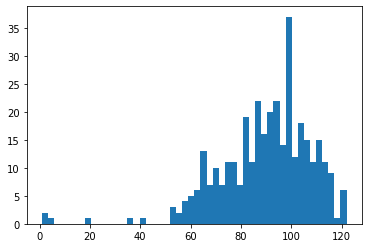

In [194]:
import matplotlib.pyplot as plt
input_lens = [len(x) for x in target_order]
plt.hist(input_lens, bins=50)

If you want the model to predict the vehicle ID during the ordering prediction, you can remove the vehicle ID from the input sequence that you provide to the model and train the model to predict it as part of the output sequence.

For example, during training, you can provide the model with a sequence of rides without the vehicle ID, and train it to output the correct order of rides along with the corresponding vehicle ID for each ride.

During inference, you can provide the model with a sequence of rides without the vehicle ID, and let it predict the correct order of rides along with the corresponding vehicle ID for each ride.

In [195]:
input_max_length=2000
target_max_length=2000

In [196]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer, BartForConditionalGeneration

checkpoint='facebook/bart-large'

model = BartForConditionalGeneration.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint, model_max_length=input_max_length, sep_token='|')



In [197]:
# Get all the text columns and concatenate them with numerical columns
text_columns = df.select_dtypes(include=['object', 'float', 'int']).astype(str).apply(lambda x: ' '.join(x.dropna()), axis=1)

# Concatenate all the text columns into one long string
text = ' '.join(text_columns)

# Split the string into a list of unique words
unique_words = list(set(text.split()))

# Write the unique words to a text file, one word per line
with open('custom_vocab.txt', 'w') as f:
    f.write('\n'.join(unique_words))



In [198]:
# Open the text file
with open('custom_vocab.txt', 'r') as f:
    # Read the contents of the file into a list
    custom_vocab = [line.split('\n')[0] for line in f.readlines()]

# Print the list
print(custom_vocab)


['199.1625', '254.4', '37.36915969848633', '58.1975', '454054', '9.201886', '209.48', '35.2653', '37.31916809082031', '3.446746', '178.04', '465129', '485596', '37.262284', '5.318316', '459184', '4.270063', '471381', '13.131437', '234.36', '104.47', '452077', '95.03', '165.6', '-121.850262', '128.8375', '-121.94716', '117.5675', '455403', '-122.140205', '329.32', '456595', '80.68', '-121.89418029785156', '113.8', '-122.13330841064452', '461788', '-121.9372923', '98.2175', '390520', '9.894715', '10.816208', '27.425', '37.26994323730469', '-121.833423', '11.216371', '0.853764', '478887', '421847', '183.725', '181.2', '47.0', '303.6', '37.48745346069336', '29.584724', '23.8925', '33.56100082397461', '32.2175', '32.1725', '37.364645', '2.923551', '8.945881', '275891', '96.4', '402.4', '133.68', '420587', '143.1975', '451.32', '388769', '0.920251', '135.52', '41.96', '12.546106', '480714', '4.505563', '13.526629', '124.5425', '253.7925', '429211', '37.33702850341797', '37.398567', '254641',

In [199]:
tokenizer.add_tokens(custom_vocab)
tokenizer.add_tokens("<SEP>")

1

In [200]:
def tokenizer_fn(batch):
    inputs = [eval(x)['input'] for x in batch['translation']]
    targets = [eval(x)['target'] for x in batch['translation']]
    
    # Join the list of strings into a single string or the tokenizer will not understand the data
    inputs = [' '.join(inp) for inp in inputs]
    targets = [' '.join(tgt) for tgt in targets]

    # Tokenize the inputs and targets
    tokenized_inputs = tokenizer(inputs, max_length=input_max_length, truncation=True)
    tokenized_targets = tokenizer(text_target=targets, max_length=target_max_length ,truncation=True)
    
    # Add the labels to the tokenized_inputs
    tokenized_inputs['labels'] = tokenized_targets['input_ids']
    
    return tokenized_inputs


In [201]:
# Apply the tokenizer function to the dataset using the 'map()' method
tokenized_datasets = dataset_dict.map(
    tokenizer_fn,
    batched=True,
    remove_columns=dataset_dict['train'].column_names
)

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

In [202]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 280
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 71
    })
})

In [203]:
# input id tokens [505, 9175, 2128, 9175, 35524, 1820, 36604, 1820, 36722, 1820, 39638, 1820, 32518, 1820, ...]
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

'<s>8|15|WCH|48.375|388526|-121.92559051513672|37.31228256225586|-121.93157196044922|37.311279296875|1.496262<SEP> 10|0|STR|133.5|424845|-122.03131|37.2799183|-121.966965|37.261959|5.976348<SEP> 13|0|WCH|100.175|390537|-121.83203887939452|37.295745849609375|-121.81209564208984|37.30604934692383|2.259927<SEP> 18|0|WCH|38.675|388702|-121.93367004394533|37.3155517578125|-121.84119415283205|37.365753173828125|8.318918<SEP> 13|0|WCH|57.225|388477|-122.06513|37.376552|-122.0266571044922|37.32122421264648|6.549252<SEP> 8|15|BWC|60.0|388851|-121.81166076660156|37.2621955871582|-121.82691192626952|37.25193786621094|2.517796<SEP> 8|30|WCH|60.075|425160|-121.89218139648438|37.28892517089844|-121.93350219726562|37.31349563598633|6.697139<SEP> 13|15|BWC|93.6|388505|-121.8270263671875|37.25196838378906|-121.8325653076172|37.33570861816406|10.860326<SEP> 5|45|BWC|77.2|388574|-121.9619140625|37.27531433105469|-121.8917007446289|37.24549102783203|6.762383<SEP> 14|0|WCH|0.0|424859|-122.0934066772461|37.

In [204]:
# label tokens [305, 9175, 1808, 9175, 35524, 1820, 39055, 1820, 39119, 1820, 35073, 1820, 5033, 9175, 5647, ...]
tokenized_datasets['train'][0]['labels']
tokenizer.decode(tokenized_datasets['train'][0]['labels'])

'<s>5|0|WCH|SC103|100.85|411690|-121.99421691894533|37.34215927124024|-121.97903442382812|37.32246398925781|2.57869<SEP> 5|0|WCH|SC105|60.325|388472|-122.00352478027344|37.40178680419922|-121.93331909179688|37.31606674194336|12.938191<SEP> 5|0|WCH|SC101|42.5|388691|-121.92430877685548|37.39934158325195|-121.93148040771484|37.31127166748047|10.029552<SEP> 5|15|BWC|SC301|154.4|388852|-121.59493255615234|37.02376937866211|-121.81209564208984|37.30604934692383|26.139221<SEP> 5|15|WCH|SC103|103.325|390534|-121.96422576904295|37.29271697998047|-121.93370819091795|37.31555938720703|3.689702<SEP> 5|30|WCH|SC105|63.8|388496|-121.84912109375|37.32672882080078|-121.8120978|37.3060479|4.43659<SEP> 5|30|WCH|SC101|58.85|390198|-121.9492645263672|37.30254364013672|-121.93370819091795|37.31555938720703|2.207732<SEP> 5|45|BWC|SC101|77.2|388574|-121.9619140625|37.27531433105469|-121.8917007446289|37.24549102783203|6.762383<SEP> 5|45|WCH|SC103|25.625|388537|-121.9513702392578|37.296607971191406|-121.9337

In [205]:
# In general, it's not uncommon for input_ids and labels to have different lengths
len(tokenized_datasets['train'][1]['input_ids']), len(tokenized_datasets['train'][1]['labels'])

(1482, 1630)

In [206]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model,)
batch = data_collator([tokenized_datasets['train'][i] for i in range(1,3)])
batch.keys()

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

The batch dictionary is training examples, and the labels key in the batch dictionary contains the labels for the corresponding input sequences. In the context of sequence-to-sequence modeling, the labels typically represent the "target" or "output" sequence that the model is being trained to generate given the corresponding input sequence.

In [207]:
batch['labels']

tensor([[    0,   245, 15483,  ..., 53821, 56072,     2],
        [    0,   245, 15483,  ...,  -100,  -100,  -100]])

Think of seq2seq RNNs, the decoder RNN must have some input. This allows the decoder to predict the next word, given the previous words from the encoder. THE DECODER IDS ARE A SHIFTED FORWARD ONE - VERSION OF THE TARGETS SO THE DECODER CAN TRAIN TO PREDICT THE NEXT TOKEN IN A SEQUENCE.

In [208]:
batch['decoder_input_ids']

tensor([[    2,     0,   245,  ..., 15483, 53821, 56072],
        [    2,     0,   245,  ...,     1,     1,     1]])

In [211]:
# the decoder input ids are shifted forward by adding the </s> at the front of the list
tokenizer.convert_ids_to_tokens(batch['decoder_input_ids'][0]) 

['</s>',
 '<s>',
 '5',
 '|',
 '0',
 '|',
 'BWC',
 '|',
 'SC201',
 '|',
 '234.36',
 '|',
 '463273',
 '|',
 '-121.91210174560548',
 '|',
 '37.25297164916992',
 '|',
 '-121.93732452392578',
 '|',
 '37.32392501831055',
 '|',
 '8.586729',
 '<SEP>',
 'Ġ5',
 '|',
 '0',
 '|',
 'WCH',
 '|',
 'SC106',
 '|',
 '83.51',
 '|',
 '388472',
 '|',
 '-122.00352478027344',
 '|',
 '37.40178680419922',
 '|',
 '-121.93370819091795',
 '|',
 '37.31555938720703',
 '|',
 '13.163749',
 '<SEP>',
 'Ġ5',
 '|',
 '15',
 '|',
 'BWC',
 '|',
 'SC103',
 '|',
 '157.44',
 '|',
 '388820',
 '|',
 '-121.9681625366211',
 '|',
 '37.321964263916016',
 '|',
 '-121.93733215332033',
 '|',
 '37.32389831542969',
 '|',
 '1.862871',
 '<SEP>',
 'Ġ5',
 '|',
 '15',
 '|',
 'WCH',
 '|',
 'SC109',
 '|',
 '101.255',
 '|',
 '388896',
 '|',
 '-121.83972930908205',
 '|',
 '37.314208984375',
 '|',
 '-121.81138610839844',
 '|',
 '37.305171966552734',
 '|',
 '2.777529',
 '<SEP>',
 'Ġ5',
 '|',
 '30',
 '|',
 'STR',
 '|',
 'SC204',
 '|',
 '0.0',
 '|',


In [210]:
# labels are in line with the target data, the decoder input ids are shifted forward
# now the model can compare the target to the predicted next token
tokenizer.convert_ids_to_tokens(batch['labels'][0])

['<s>',
 '5',
 '|',
 '0',
 '|',
 'BWC',
 '|',
 'SC201',
 '|',
 '234.36',
 '|',
 '463273',
 '|',
 '-121.91210174560548',
 '|',
 '37.25297164916992',
 '|',
 '-121.93732452392578',
 '|',
 '37.32392501831055',
 '|',
 '8.586729',
 '<SEP>',
 'Ġ5',
 '|',
 '0',
 '|',
 'WCH',
 '|',
 'SC106',
 '|',
 '83.51',
 '|',
 '388472',
 '|',
 '-122.00352478027344',
 '|',
 '37.40178680419922',
 '|',
 '-121.93370819091795',
 '|',
 '37.31555938720703',
 '|',
 '13.163749',
 '<SEP>',
 'Ġ5',
 '|',
 '15',
 '|',
 'BWC',
 '|',
 'SC103',
 '|',
 '157.44',
 '|',
 '388820',
 '|',
 '-121.9681625366211',
 '|',
 '37.321964263916016',
 '|',
 '-121.93733215332033',
 '|',
 '37.32389831542969',
 '|',
 '1.862871',
 '<SEP>',
 'Ġ5',
 '|',
 '15',
 '|',
 'WCH',
 '|',
 'SC109',
 '|',
 '101.255',
 '|',
 '388896',
 '|',
 '-121.83972930908205',
 '|',
 '37.314208984375',
 '|',
 '-121.81138610839844',
 '|',
 '37.305171966552734',
 '|',
 '2.777529',
 '<SEP>',
 'Ġ5',
 '|',
 '30',
 '|',
 'STR',
 '|',
 'SC204',
 '|',
 '0.0',
 '|',
 '421840'

In [212]:
dataset_dict['train'][0]

{'id': 33,
 'translation': "{'input': ['8|15|WCH|48.375|388526|-121.92559051513672|37.31228256225586|-121.93157196044922|37.311279296875|1.496262<SEP>', '10|0|STR|133.5|424845|-122.03131|37.2799183|-121.966965|37.261959|5.976348<SEP>', '13|0|WCH|100.175|390537|-121.83203887939452|37.295745849609375|-121.81209564208984|37.30604934692383|2.259927<SEP>', '18|0|WCH|38.675|388702|-121.93367004394533|37.3155517578125|-121.84119415283205|37.365753173828125|8.318918<SEP>', '13|0|WCH|57.225|388477|-122.06513|37.376552|-122.0266571044922|37.32122421264648|6.549252<SEP>', '8|15|BWC|60.0|388851|-121.81166076660156|37.2621955871582|-121.82691192626952|37.25193786621094|2.517796<SEP>', '8|30|WCH|60.075|425160|-121.89218139648438|37.28892517089844|-121.93350219726562|37.31349563598633|6.697139<SEP>', '13|15|BWC|93.6|388505|-121.8270263671875|37.25196838378906|-121.8325653076172|37.33570861816406|10.860326<SEP>', '5|45|BWC|77.2|388574|-121.9619140625|37.27531433105469|-121.8917007446289|37.24549102783